In [13]:
import sys 
sys.path.append("../../")
import pandas as pd
from br_demography  import municipality_demographic_profiling as mdp
from dotenv import load_dotenv
import os
import numpy as np
from br_demography  import municipality_pop_pyramid as mep
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carrega as variáveis de ambiente do arquivo .env
load_dotenv(dotenv_path='../../.env')

# Use as variáveis de ambiente conforme necessário
project_id = os.getenv('GOOGLE_CLOUD_PROJECT_ID')

In [14]:
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', index_col='mun_id')
df_deaths = mdp.query_interest_vars(mun_ids=df_mun.index.astype(str).to_list(), project_id=project_id, start_year=2000, end_year=2019)

#df_deaths[df_deaths.Idade.isna()].groupby(by=['mun_id', 'Ano']).size().sort_values(ascending=False).sum()

Downloading: 100%|██████████| 202575/202575 [00:03<00:00, 54849.02rows/s]


## Mortalidade

In [15]:
df_births = mdp.query_births(mun_ids=df_mun.index.astype(str).to_list(), project_id=project_id, start_year=2000, end_year=2019)

Downloading: 100%|██████████| 993528/993528 [00:11<00:00, 85530.60rows/s]


In [16]:
df_temp = (df_deaths[df_deaths['Idade'] < 1].groupby(by=['mun_id', 'Ano']).size().unstack().sum(axis=1) / df_births.groupby(by=['mun_id', 'Ano']).size().unstack().sum(axis=1)).to_frame()

In [17]:
df_temp.rename(columns={0:'Aggregated Child Death Rate'}, inplace=True)
df_temp.index = df_temp.index.astype(int)
df_temp = df_temp.join(df_mun).reset_index().set_index(['mun']).drop(columns=['mun_id'])


In [18]:
df_temp = df_temp[df_temp.index !='Curitiba']

In [19]:
df = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [20]:
df

,Aggregated Child Death Rate
mun,
Adrianópolis,0.864413
Agudos do Sul,0.386976
Almirante Tamandaré,0.172990
Araucária,0.110313
Balsa Nova,0.165496
Bocaiúva do Sul,1.000000
Campina Grande do Sul,0.526395
Campo do Tenente,0.109652
Campo Largo,0.306067


## Porte Populacional

In [21]:
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', index_col='mun_id')

dict_dfs = dict()

for mun_id, mun in df_mun.itertuples():

    df_age_pyramid_2022 = mep.query_total_pop_by_sex_age_2022(mun_id=mun_id, project_id=project_id)

    df_age_pyramid_2022 = mep.standard_age_groups(df=df_age_pyramid_2022, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_censo_2022.csv', year=2022)

    df_age_pyramid_2022['mun'] = mun
    
    dict_dfs[mun] = df_age_pyramid_2022

df_pop = pd.concat(objs=dict_dfs.values())
df_pop = df_pop.reset_index().groupby(by=['mun'])[['Pop']].sum()


Downloading: 100%|██████████| 42/42 [00:00<00:00, 128.69rows/s]


In [22]:
df

,Aggregated Child Death Rate
mun,
Adrianópolis,0.864413
Agudos do Sul,0.386976
Almirante Tamandaré,0.172990
Araucária,0.110313
Balsa Nova,0.165496
Bocaiúva do Sul,1.000000
Campina Grande do Sul,0.526395
Campo do Tenente,0.109652
Campo Largo,0.306067


In [23]:
df = df.join(pd.DataFrame((df_pop - df_pop.min()) / (df_pop.max() - df_pop.min())))

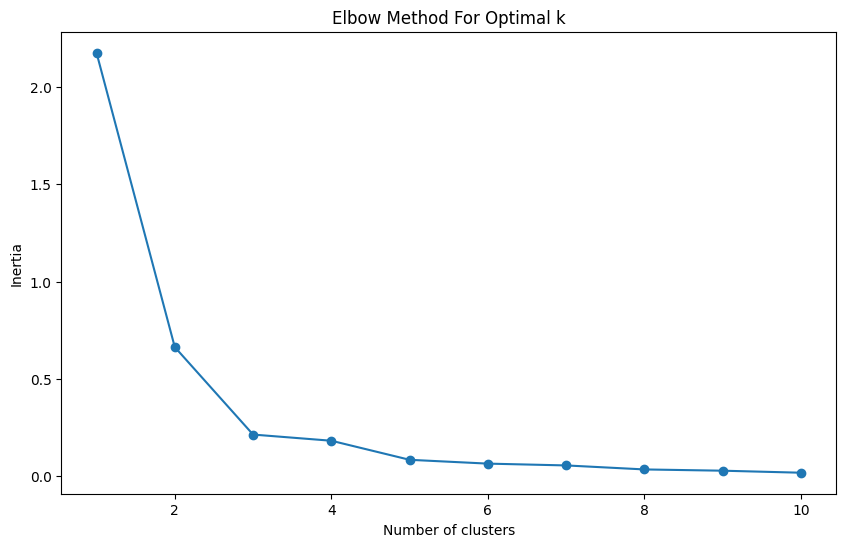

In [24]:
inertia = []
for n in range(1, 11):
#    kmeans = KMeans(n_clusters=n, random_state=42).fit(df[['Pop']])
    kmeans = KMeans(n_clusters=n, random_state=42).fit(df)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [41]:
# Applying KMeans with the chosen number of clusters
#kmeans = KMeans(n_clusters=3, random_state=42).fit(df[['Pop']])

kmeans = KMeans(n_clusters=4, random_state=42).fit(df)

# Assigning the clusters to the dataframe
df['grupos'] = kmeans.labels_

df

,Aggregated Child Death Rate,Pop,grupos
mun,,,
Adrianópolis,0.864413,0.000316,0
Agudos do Sul,0.386976,0.002566,3
Almirante Tamandaré,0.172990,0.064551,2
Araucária,0.110313,0.082561,2
Balsa Nova,0.165496,0.004354,2
Bocaiúva do Sul,1.000000,0.0043,0
Campina Grande do Sul,0.526395,0.023828,3
Campo do Tenente,0.109652,0.001024,2
Campo Largo,0.306067,0.073885,1


In [42]:
import geopandas as gpd

In [43]:
gdf_rmc = gpd.read_file('../../br_demography/source/shp/pdui/limites_municipais.shp')

In [44]:
gdf_rmc.rename(columns={'nome':'mun'}, inplace=True)

In [45]:
gdf_rmc.set_index('mun', inplace=True)

In [46]:
gdf_rmc = gdf_rmc.join(df[['grupos']])

In [47]:
gdf_rmc['grupos'] = gdf_rmc['grupos'].fillna(4)

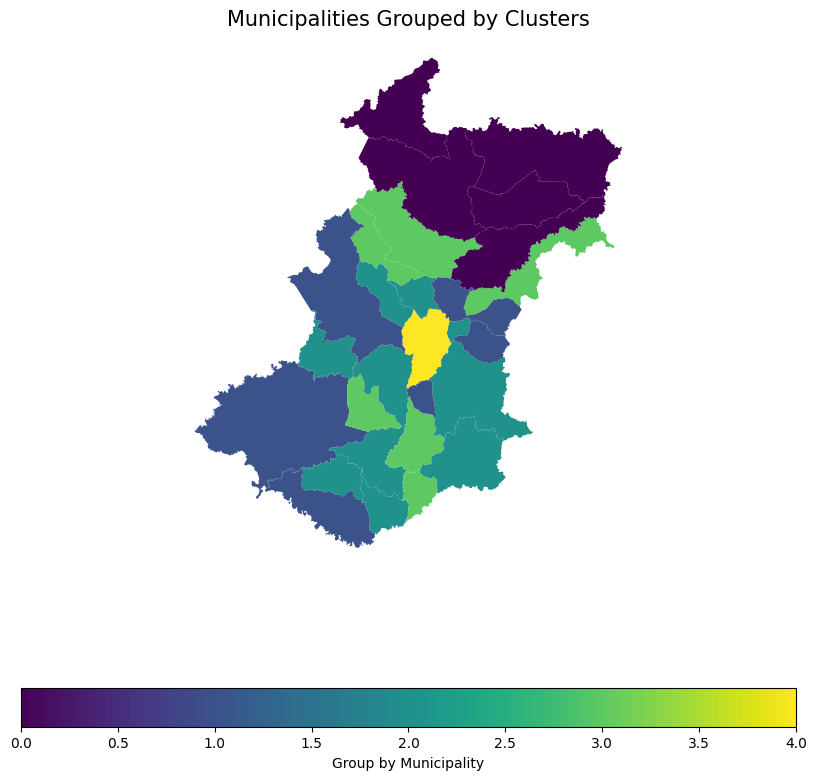

In [48]:
# Plotting the GeoDataFrame where the color represents different groups
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_rmc.plot(column='grupos', ax=ax, legend=True, 
             legend_kwds={'label': "Group by Municipality",
                          'orientation': "horizontal"})

# Optional: Remove x and y axis for cleaner look
ax.set_axis_off()

# Add title
ax.set_title('Municipalities Grouped by Clusters', fontsize=15)

plt.show()

In [106]:
df_deaths.set_index(['mun_id'], inplace=True)
df_deaths.index = df_deaths.index.astype(int)

In [110]:
df_deaths = df_deaths.join(df_mun).reset_index().drop(columns=['mun_id'])

In [122]:
df_deaths

,mun,Ano,Idade
0,Adrianópolis,2000,0.00
1,Adrianópolis,2000,0.00
2,Adrianópolis,2000,0.04
3,Adrianópolis,2000,0.25
4,Adrianópolis,2000,0.33
...,...,...,...
202570,Doutor Ulysses,2019,85.00
202571,Doutor Ulysses,2019,85.00
202572,Doutor Ulysses,2019,89.00
202573,Doutor Ulysses,2019,91.00


In [138]:
df_65_mais_deaths = (
    df_deaths[df_deaths['Idade'] >= 65]
    .groupby(by=['mun', 'Ano'])
    .size()
    .unstack()
    .iloc[:,10:]
    .rename_axis(columns=None)
)

In [90]:
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', index_col='mun_id')

dict_dfs = dict()

for mun_id, mun in df_mun.itertuples():

    df_age_pyramid_2022 = mep.query_total_pop_by_sex_age_2022(mun_id=mun_id, project_id=project_id)
    df_age_pyramid_2010 = mep.query_total_pop_by_sex_age_2010(mun_id=mun_id, project_id=project_id)

    df_age_pyramid_2022 = mep.standard_age_groups(df=df_age_pyramid_2022, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_censo_2022_65_anos_mais.csv', year=2022)
    df_age_pyramid_2010 = mep.standard_age_groups(df=df_age_pyramid_2010, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_censo_2000_2010_65_anos_mais.csv', year=2010)

    df_age_pyramid = mep.concatenate_treated_dfs(dfs=[df_age_pyramid_2022, df_age_pyramid_2010])

    df_age_pyramid = mep.concatenate_treated_dfs(dfs=[df_age_pyramid_2022, df_age_pyramid_2010])

    # Criação do DataFrame df_taxa_crecimento_pop
    df_taxa_crecimento_pop = pd.DataFrame()

    # Cálculo de taxa de crescimento geométrico anual para cada período intercensitário
    df_taxa_crecimento_pop['2010 a 2022'] = (df_age_pyramid[2022] / df_age_pyramid[2010])**(1/(2022-2010)) - 1

    # Iteração a partir das taxas de crescimento e estimativa da população para cada faixa etária e sexo por ano intercensitário
    for taxa in df_taxa_crecimento_pop.columns:
        ano_inicial, ano_final = [int(ano.strip()) for ano in taxa.split('a')]    
        for ano in range(ano_inicial, ano_final):
            #inserção dos dados calculados em novas colunas do DataFrame df_age_pyramid
            df_age_pyramid[ano] = (df_age_pyramid[ano_inicial]*((1+ df_taxa_crecimento_pop[taxa])**(ano-ano_inicial))) #.astype(int)


    # reorganização da ordem das colunas, de 1996 a 2022 no DataFrame
    df_age_pyramid = df_age_pyramid[range(df_age_pyramid.columns.min(), df_age_pyramid.columns.max()+1)]


    df_age_pyramid = df_age_pyramid.fillna(0).astype(int)

    df_age_pyramid['Município'] = mun
    df_age_pyramid = df_age_pyramid.reset_index().set_index(['Município', 'Sexo', 'Faixa Etária'])

    dict_dfs[mun] = df_age_pyramid

df_65_mais = pd.concat(objs=dict_dfs.values())


Downloading: 100%|██████████| 177/177 [00:00<00:00, 570.76rows/s]


In [94]:
df_65_mais.reset_index(inplace=True)
df_65_mais.rename(columns={'Município':'mun'}, inplace=True)

In [137]:
df_65_mais = (
    df_65_mais
    .loc[df_65_mais['Faixa Etária'] == '65 anos ou mais']
    .groupby(by=['mun']).sum()
    .iloc[:,:-3]

)

In [141]:
df_mean_death_rate = (df_65_mais_deaths / df_65_mais).mean(axis=1)

In [145]:
pd.DataFrame((df_mean_death_rate - df_mean_death_rate.min()) / (df_mean_death_rate.max() - df_mean_death_rate.min()))

,0
mun,
Adrianópolis,0.397436
Agudos do Sul,0.235877
Almirante Tamandaré,0.758110
Araucária,0.686677
Balsa Nova,0.667959
Bocaiúva do Sul,0.223035
Campina Grande do Sul,0.726874
Campo Largo,0.506221
Campo Magro,0.602294


In [87]:
df_age_pyramid_2022

Pop
Ano  Sexo      Faixa Etária         
2022 Feminino  até 65 anos      2462
               65 anos ou mais   270
     Masculino até 65 anos      2635
               65 anos ou mais   330

In [16]:
df_births.groupby(by=['mun_id', 'Ano']).size()

mun_id   Ano 
4100202  2000    88
         2001    75
         2002    88
         2003    97
         2004    89
                 ..
4128633  2015    75
         2016    66
         2017    70
         2018    80
         2019    68
Length: 580, dtype: int64

In [18]:
df_births.groupby(by=['mun_id', 'Ano']).size().unstack().sum(axis=1)

mun_id
4100202      1646
4100301      2244
4100400     36444
4101804     42549
4102307      3460
4103107      3477
4104006     14940
4104105      2413
4104204     33444
4104253      7873
4105201      5206
4105805     74480
4106209      4305
4106902    495826
4107652     31681
4111258      9638
4113205     13351
4114302      7381
4119103      3180
4119152     39746
4119509     30223
4120804      6313
4121208      4264
4122206     12472
4122305      8549
4125506     89735
4127601      4438
4127882      2666
4128633      1584
dtype: int64

In [7]:
df_deaths[(df_deaths['Idade'] == 0) & (df_deaths['mun_id'] == '4100202')]

,mun_id,Ano,Idade
8057,4100202,1997,0.0
15909,4100202,1998,0.0
32320,4100202,2000,0.0
32328,4100202,2000,0.0
40566,4100202,2001,0.0
49018,4100202,2002,0.0
83973,4100202,2006,0.0
93180,4100202,2007,0.0


In [12]:
df_deaths[df_deaths['Idade'] < 1].groupby(by=['mun_id', 'Ano']).size().unstack()

Ano,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
mun_id,,,,,,,,,,,,,,,,,,,,,
4100202,6.0,3.0,4.0,2.0,6.0,5.0,3.0,1.0,4.0,NaN,...,NaN,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4100301,5.0,6.0,8.0,NaN,2.0,1.0,1.0,2.0,1.0,4.0,...,1.0,NaN,3.0,2.0,1.0,NaN,4.0,NaN,NaN,2.0
4100400,59.0,47.0,61.0,49.0,44.0,45.0,26.0,25.0,23.0,28.0,...,16.0,12.0,22.0,16.0,14.0,17.0,13.0,8.0,10.0,14.0
4101804,60.0,44.0,47.0,48.0,29.0,27.0,28.0,33.0,27.0,30.0,...,30.0,20.0,29.0,20.0,16.0,24.0,25.0,21.0,13.0,22.0
4102307,4.0,3.0,1.0,3.0,5.0,1.0,1.0,1.0,1.0,2.0,...,2.0,1.0,NaN,2.0,3.0,1.0,NaN,1.0,3.0,NaN
4103107,8.0,3.0,9.0,6.0,5.0,5.0,5.0,1.0,3.0,NaN,...,2.0,7.0,2.0,6.0,4.0,3.0,1.0,NaN,3.0,3.0
4104006,7.0,21.0,29.0,14.0,22.0,14.0,19.0,20.0,11.0,14.0,...,12.0,13.0,5.0,13.0,7.0,8.0,12.0,9.0,4.0,11.0
4104105,1.0,2.0,3.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,...,4.0,NaN,1.0,4.0,NaN,1.0,1.0,1.0,2.0,2.0
4104204,43.0,33.0,39.0,42.0,30.0,32.0,27.0,29.0,23.0,25.0,...,23.0,17.0,14.0,23.0,23.0,19.0,21.0,17.0,16.0,11.0


In [14]:
df_pop = pd.read_csv(filepath_or_buffer='../../br_demography/results/tab/pop_municipios_rmc_2000_2022_estimativa_intercensitaria.csv', sep=';')
#df_pop[df_pop['Faixa Etária'].isin(values=df_deaths.index)]
#df_pop.set_index(keys=['Município', 'Sexo','Faixa Etária'], inplace=True)
#df_pop.columns = df_pop.columns.astype(int)
df_pop.iloc[np.r_[0:2, -2:0]]

,Município,Sexo,Faixa Etária,2000,2001,2002,2003,2004,2005,2006,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Adrianópolis,Feminino,0 a 9 anos,704,681,660,639,619,599,580,...,486,478,470,462,455,447,440,433,425,419
1,Adrianópolis,Feminino,10 a 19 anos,823,798,775,752,730,708,687,...,576,565,555,545,534,524,515,505,496,487
520,Doutor Ulysses,Masculino,70 a 79 anos,79,79,80,81,82,83,84,...,100,104,108,112,117,122,127,132,137,143
521,Doutor Ulysses,Masculino,80 anos ou mais,22,23,24,26,28,30,31,...,45,47,49,50,52,54,56,58,60,63


In [11]:
df_deaths

,mun_id,Ano,Idade
0,4100400,1996,0.0
1,4100400,1996,0.0
2,4100400,1996,0.0
3,4100400,1996,0.0
4,4101804,1996,0.0
...,...,...,...
256616,4125506,2021,108.0
256617,4111258,2021,109.0
256618,4106902,2021,109.0
256619,4105805,2021,109.0


In [8]:
mun_ids = df_mun.index.astype(str).to_list()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Example DataFrame 'df' with columns: 'Município', 'Sexo', 'Faixa Etária', '2000', '2001', ..., '2019'

# Function to calculate the slope of mortality rates over years
def calculate_slope(years, values):
    model = LinearRegression()
    model.fit(years.reshape(-1, 1), values)
    return model.coef_[0]

# Prepare years array for slope calculation
years = np.array(range(2000, 2020)).reshape(-1, 1)

# Calculating mean and slope for each municipality and age group
def process_group(group):
    mean = group.iloc[:, 4:].mean(axis=1).mean()  # Mean mortality rate
    slope = calculate_slope(years, group.iloc[:, 4:].mean().values)  # Slope of mortality rates
    return pd.Series([mean, slope], index=['mean', 'slope'])

# Applying the function to each municipality and specified age groups
result = df.groupby(['Município', 'Faixa Etária']).apply(process_group).unstack()

# Filtering for specific age groups and renaming columns
filtered_result = result.loc[:, (slice(None), ['0 a 9 anos', '80 anos ou mais'])]
filtered_result.columns = ['female-0to9-mean', 'female-80plus-mean', 'female-0to9-slope', 'female-80plus-slope']

# Scaling the slope columns to [0, 1] range (assuming they are all positive for simplicity)
# Adjust this part if you have negative slopes or apply a log transformation before scaling
scaler = MinMaxScaler()
filtered_result[['female-0to9-slope', 'female-80plus-slope']] = scaler.fit_transform(filtered_result[['female-0to9-slope', 'female-80plus-slope']])

# The 'filtered_result' DataFrame now has the simplified and scaled features for clustering
print(filtered_result.head())

# Now, you can proceed with clustering or further analysis on 'filtered_result'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame columns: 'Município', 'Sexo', 'Faixa Etária', '2000', '2001', ..., '2019'

# Calculating polyfit slopes for each municipality, sex, and age group combination
def calculate_slope(row):
    years = np.array(range(len(row)))  # Assuming consecutive years without gaps
    return np.polyfit(years, row, 1)[0]  # [0] to get the slope

# Apply the function across rows for each year's data, grouping by 'Município', 'Sexo', 'Faixa Etária'
df['slope'] = df.loc[:, '2000':'2019'].apply(calculate_slope, axis=1)

# Aggregating slopes by municipality to create a feature set
# Here, you might aggregate slopes in various ways (mean, median, variance, etc.)
features_df = df.groupby('Município')['slope'].agg(['mean', 'std']).reset_index()

# Elbow Method to determine the optimal number of clusters
inertia = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(features_df.iloc[:, 1:])
    inertia.append(kmeanModel.inertia_)

# Plotting the Elbow Plot
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()